In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
import time
import glob

BASE_DIR = os.path.abspath("..")
PROC_DIR = os.path.join(BASE_DIR, "processed")
MODELS_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)
CLASSES = ["NORMAL", "PNEUMONIA"]

class ChestXRayDataset(Dataset):
    def __init__(self, split="train", transform=None):
        self.split = split
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for idx, cls in enumerate(CLASSES):
            pattern = os.path.join(PROC_DIR, split, cls, "*.png")
            for fp in glob.glob(pattern):
                self.image_paths.append(fp)
                self.labels.append(idx)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
            
        label = self.labels[idx]
        return image, label

data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

train_dataset = ChestXRayDataset(split="train", transform=data_transforms['train'])
val_dataset = ChestXRayDataset(split="val", transform=data_transforms['val'])
test_dataset = ChestXRayDataset(split="test", transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Taille du dataset d'entraînement: {len(train_dataset)}")
print(f"Taille du dataset de validation: {len(val_dataset)}")
print(f"Taille du dataset de test: {len(test_dataset)}")

Taille du dataset d'entraînement: 5216
Taille du dataset de validation: 16
Taille du dataset de test: 624


In [5]:
def create_model():
    model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    
    for param in model.parameters():
        param.requires_grad = False
    
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 2)
    )
    
    return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = create_model()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Entraînement terminé en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Meilleure précision sur validation: {best_acc:4f}')
    
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, criterion, optimizer, num_epochs=10)

torch.save(model.state_dict(), os.path.join(MODELS_DIR, "resnet18_pneumonia.pth"))

Epoch 1/10
----------
train Loss: 0.2872 Acc: 0.8786
val Loss: 0.2332 Acc: 0.8750

Epoch 2/10
----------
train Loss: 0.1863 Acc: 0.9254
val Loss: 0.6958 Acc: 0.6250

Epoch 3/10
----------
train Loss: 0.1747 Acc: 0.9344
val Loss: 0.3417 Acc: 0.8125

Epoch 4/10
----------
train Loss: 0.1704 Acc: 0.9312
val Loss: 0.6853 Acc: 0.6250

Epoch 5/10
----------
train Loss: 0.1581 Acc: 0.9400
val Loss: 0.8218 Acc: 0.6250

Epoch 6/10
----------
train Loss: 0.1578 Acc: 0.9396
val Loss: 0.4496 Acc: 0.7500

Epoch 7/10
----------
train Loss: 0.1654 Acc: 0.9365
val Loss: 0.5752 Acc: 0.6250

Epoch 8/10
----------
train Loss: 0.1481 Acc: 0.9461
val Loss: 0.4362 Acc: 0.6875

Epoch 9/10
----------
train Loss: 0.1485 Acc: 0.9434
val Loss: 0.3325 Acc: 0.8125

Epoch 10/10
----------
train Loss: 0.1350 Acc: 0.9480
val Loss: 0.5475 Acc: 0.6875

Entraînement terminé en 57m 3s
Meilleure précision sur validation: 0.875000


Précision sur le test: 0.8558

Rapport de classification:
              precision    recall  f1-score   support

      NORMAL       0.94      0.65      0.77       234
   PNEUMONIA       0.82      0.98      0.89       390

    accuracy                           0.86       624
   macro avg       0.88      0.82      0.83       624
weighted avg       0.87      0.86      0.85       624



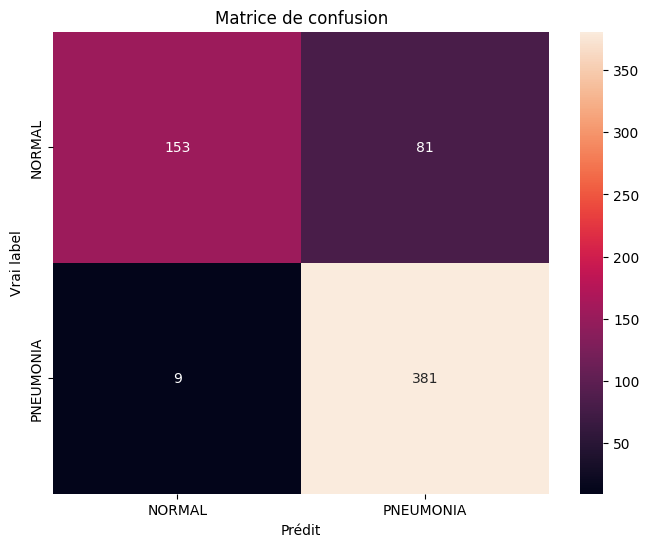

In [6]:
def evaluate_model(model, dataloader):
    model.eval()
    
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = running_corrects.double() / len(dataloader.dataset)
    print(f'Précision sur le test: {acc:.4f}')
    
    from sklearn.metrics import classification_report, confusion_matrix
    print("\nRapport de classification:")
    print(classification_report(all_labels, all_preds, target_names=CLASSES))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    import seaborn as sns
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title('Matrice de confusion')
    plt.ylabel('Vrai label')
    plt.xlabel('Prédit')
    plt.show()
    
    return all_preds, all_labels

all_preds, all_labels = evaluate_model(model, test_loader)